## [적대적 예제 생성(Adversarial example Generation)](https://tutorials.pytorch.kr/beginner/fgsm_tutorial.html)
> 이 튜토리얼은 ML 모델들의 보안 취약점에 대한 인식을 높이고, 요즘 화두가 되고 있는 적대적 머신러닝에 대한 통찰력을 제공할 것입니다. 이미지에 눈치챌 수 없는 작은 변화(perturbation)를 추가하면 모델 성능이 크게 달라질 수 있다는 사실에 놀랄 수 있습니다. 이번 튜토리얼에서는 이미지 분류기의 예제를 통해 위 내용에 대해 살펴볼 것입니다. 특히 우리가 가장 많이 사용되는 공격 방법 중 하나인 FGSM(Fast Gradient Sign Attack)을 이용해 MNIST 분류기를 속여 볼 것입니다.

In [1]:
from __future__ import print_function

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets, transforms

import numpy as np 
import matplotlib.pyplot as plt 
plt.ion()


In [2]:
# MNIST 데이터셋을 내려받을 때, "User-agent" 관련한 제한을 푸는 코드입니다.  
# 더 자세한 내용: https://tutorials.pytorch.kr/beginner/fgsm_tutorial.html
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## 구현
> 이 섹션에서는 튜토리얼의 입력 매개 변수에 대해 설명하고 공격중인 모델을 정의한 다음 공격을 코딩하고 일부 테스트를 실행합니다.  
  
### 입력
- epsilons: 실행에 사용할 엡실론의 리스트입니다. 엡실론 0의 값은 원래 테스트 셋의 모델 성능을 나타내므로 목록에 유지하는 것이 중요합니다. 또한 직관적으로 엡실론이 클수록 작은 변화가 더 눈에 띄지만 모델 정확도를 저하 시키는 측면에서 더 효과가 있습니다. 여기서 데이터의 범위는 0-1 이기 때문에 엡실론의 값은 1을 초과할 수 없습니다. 
- pretrained_model: 미리 학습된 모델
- use_cuda: CUDA를 사용할지 말지 정하는 이진 플래그

In [3]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = './pretrained_models/lenet_mnist_model.pth'
use_cuda = False

### 공격을 받는 모델
> 공격을 받는 모델은 pytorch/examples/mnist와 동일한 MNIST 모델입니다. 본인의 NMIST 모델을 학습 및 저장하는 방식으로 하거나 제공된 모델을 다운로드 해 사용하는 식으로 진행할 수 있습니다. 이 섹션의 목적은 모델과 데이터 로더를 정의한 다음, 모델을 초기화하고 미리 학습된 가중치를 읽어오는 것입니다.

In [4]:
# LeNet model
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [9]:
# MNIST 테스트 데이터셋과 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
  datasets.MNIST(
    '../../data', train=False, download=True,
    transform=transforms.Compose([
      transforms.ToTensor()
    ])
  ), batch_size=1, shuffle=True
)

In [10]:
# 어떤 디바이스를 사용할지 정의
print(f'CUDA Available: {torch.cuda.is_available()}')
device = torch.device('cuda' if (use_cuda and torch.cuda.is_available()) else 'cpu')

CUDA Available: False


In [11]:
# 모델 초기화
model = Net().to(device)

In [12]:
# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [13]:
# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM 공격
> 이제 원래 입력을 교란시켜 적대적인 예를 만드는 함수를 정의 할 수 있습니다. `fgsm_attack` 함수는 입력 파라미터로 3가지를 가집니다. 첫번째는 원본 이미지, 두번째는 엡실론으로 픽셀 단위의 작은 변화를 주는 값입니다. 마지막은 data_grad로 입력 영상에 대한 변화도 손실 값입니다.  
> 데이터의 원래 범위를 유지하기 위해, 작은 변화가 적용된 이미지가 `[0,1]` 범위로 잘립니다.

In [14]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
  # data_grad의 요소별 부호 값을 얻어옴
  sign_data_grad = data_grad.sign()
  # 입력 이미지의 각 픽셀에 sign_data_grad를 적용해 작은 변화가 적용된 이미지를 생성합니다.
  perturbed_image = image + (epsilon * sign_data_grad)
  # 값 범위를 [0,1] 로 유지하기 위해 자르기(clipping)를 추가
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # 작은 변화가 적용된 이미지를 리턴합니다.
  return perturbed_image

### 테스팅 함수
> 마지막으로 본 튜토리얼의 학샘 결과는 `테스트`함수에서 오게 됩니다. 이 테스트 기능을 호출 할 때마다 NMIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 보고합니다. 그러나 이 함수에는 엡실론 입력도 필요합니다. 이는 `테스트` 함수가 엡실론 크기에 따라 공격자의 공격을 받는 모델의 정확도를 보고하기 때문입니다. 더 구체적으로 보면 테스트 셋의 각각의 샘플에서 테스트 함수는 입력 데이터에 대한 손실 변화도를 계산하고  `FGSM 공격`을 받은 작은 변화가 적용된 이미지를 만들고 나서 작은 변화가 적용된 이미지가 적대적으로 확인을 합니다.    
> 추가로 모델의 정확도를 테스트하기 위해서 테스트 함수는 나중에 시각화하여 볼 수 있도록 성공적으로 얻은 적대적 이미지를 저장하고 반환합니다.

In [18]:
def test(model, device, test_loader, epsilon):
  # 정확도 카운터
  correct = 0
  adv_examples = [] 
  # 테스트 셋의 모든 예제에 대해 루프를 돕니다.
  for data, target in test_loader:
    # 디바이스(cpu or gpu)에 데이터와 라벨 값을 보냅니다.
    data, target = data.to(device), target.to(device)
    # 텐서의 속성 중 requires_grad를 설정합니다. 공격에서 중요한 부분입니다.
    data.requires_grad = True 
    # 데이터를 모델에 통과시킵니다.
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인텍스를 얻습니다.
    # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다.
    if init_pred.item() != target.item():
      continue
    # 손실을 계산합니다.
    loss = F.nll_loss(output, target)
    # 모델의 변화도들을 전부 0으로 설정
    model.zero_grad()
    # 후방 전달을 통해 모델의 변화도를 계산
    loss.backward()
    # 변화도 값을 모읍니다.
    data_grad = data.grad.data
    # FGSM 공격을 호출합니다.
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    # 작은 변화가 적용된 이미지에 대해 재분류합니다.
    output = model(perturbed_data)
    # 올바른지 확인
    final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스 얻습니다.
    if final_pred.item() == target.item():
      correct += 1
      # 0 앱실론 예제에 대해서 저장합니다.
      if (epsilon == 0) and (len(adv_examples) < 5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    else:
      # 추후 시각화를 위해 다른 예제들을 저장
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
  
  # 해당 엡실론에서의 최종 정확도를 계산
  final_acc = correct / float(len(test_loader))
  print(f'Epsilon: {epsilon} \t Test Accuracy = {correct} / {len(test_loader)} = {final_acc}')
  return final_acc, adv_examples

### 공격 실행
> 구현의 마지막 부분은 공격을 실행하는 것입니다. 여기서 전체 테스트 스텝을 각 엡실론 값에 실행합니다. 각 엡실론마다 최종 정확도와 성공적인 일부 적대 사례를 저장하여 다음 섹션에 표시합니다. 앱실론 값이 증가함에 따라 출력된 정확도가 어떻게 감소하는지 보십시오. 또한 엡실론이 0인 경우에는 공격이 없는 원본 테스트 정확도임을 보입니다.

In [19]:
accuracies = [] 
examples = []

# 각 앱실론에 대해 테스트 함수를 실행
for eps in epsilons:
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

Epsilon: 0 	 Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05 	 Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1 	 Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15 	 Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2 	 Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25 	 Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3 	 Test Accuracy = 869 / 10000 = 0.0869


### 정확도 vs 앱실론
> 첫 번째 결과는 정확도 vs 엡실론을 도식화 한 것입니다. 앞에서 언급했듯이, 엡실론이 증가합에 따라 우리는 테슽 정확도가 감소할 것으로 예상합니다. 이는 학습을 더 진행해 갈수록 엡실론이 클수록 손실을 극대화 할 방향으로 진행되기 때문입니다. 엡실론 값이 선형적으로 분포하더라도 곡선의 추세는 선형의 형태가 아닙니다. 

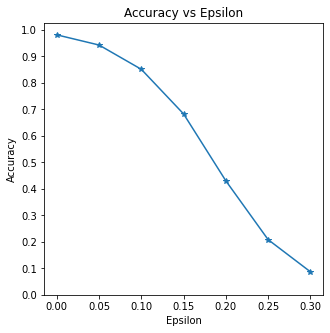

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

### 샘플 적대적 에제들
> 공짜 점심은 없다는 것을 기억하시나요? 이 경우에는 엡실론이 증가할수록 테스트 정확도는 떨어집니다. 그러나 작은 변화는 더 쉽게 인식할 수 있게 됩니다. 실제로 정확도 저하와 공격자가 고려해야 하는 이해도 사이에는 상충 관계(tradeoff)가 있습니다.   
> 여기서 우리는 각 엡실론 값에서 성공적인 대적 사례를 보이는 몇 가지 예를 보겠습니다. 아래 이미지의 첫번째로 열은 엡실론 0인 예제들로 작은 변화가 없는 원본의 '깨끗한' 이미지들을 나타냅니다. 각 이미지의 위의 글자는 '원래 분류 결과 -> 적대적 분류 결과'를 나타냅니다. 엡실론 0.15에서 작은 변화가 눈에 띄기 시작하고 엡실론 0.3에서는 확실해 보입니다.   
> 그러나 모든 경우에 대해서 노이즈가 추가되었더라도 사람은 올바르게 분류를 수행할 수 있습니다.

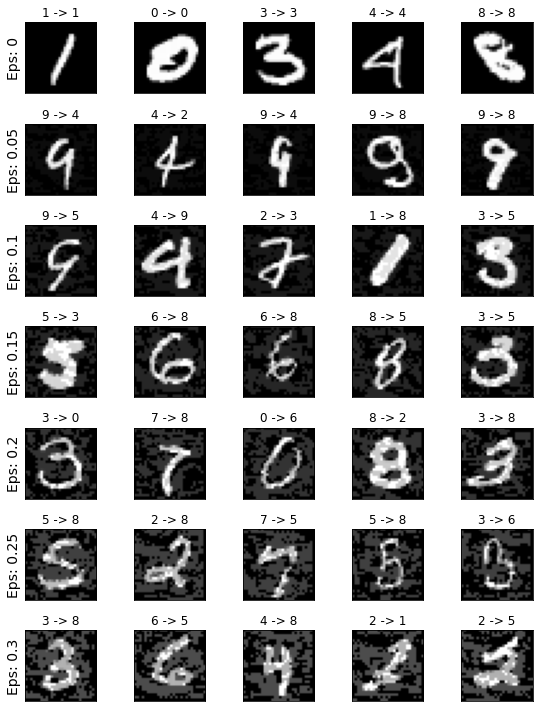

In [21]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다.
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
  for j in range(len(examples[i])):
    cnt += 1
    plt.subplot(len(epsilons), len(examples[0]), cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
      plt.ylabel(f'Eps: {epsilons[i]}', fontsize=14)
    orig, adv, ex = examples[i][j]
    plt.title(f'{orig} -> {adv}')
    plt.imshow(ex, cmap='gray')

plt.tight_layout()
plt.show()